In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import BertModel, BertTokenizer, BertConfig, BertForSequenceClassification, TFBertModel
train_df = pd.read_csv('../input/dataset2/re-designed_train_df.csv')
train_df.drop('Unnamed: 0', axis=1, inplace=True)
train_df.head()

,SID,lemmatized,negative - AMBIENCE#GENERAL,negative - DRINKS#PRICES,negative - DRINKS#QUALITY,negative - DRINKS#STYLE_OPTIONS,negative - FOOD#PRICES,negative - FOOD#QUALITY,negative - FOOD#STYLE_OPTIONS,negative - LOCATION#GENERAL,...,positive - DRINKS#QUALITY,positive - DRINKS#STYLE_OPTIONS,positive - FOOD#PRICES,positive - FOOD#QUALITY,positive - FOOD#STYLE_OPTIONS,positive - LOCATION#GENERAL,positive - RESTAURANT#GENERAL,positive - RESTAURANT#MISCELLANEOUS,positive - RESTAURANT#PRICES,positive - SERVICE#GENERAL
0,1000:0,manzara sahane evet servis rezalet,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000:1,soguk su istemek soguk yok butun sulari disari...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000:2,yemek iyi hos lezzet iyi heyecan veri bi taraf...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1000:3,servis fiyat cok fazla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000:4,lacivert kalite dusukluguyle cok sasirtti,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
texts = list(train_df["lemmatized"])
label_names = train_df.drop(["SID", "lemmatized"], axis=1).columns
labels = train_df[label_names].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

sample_idx = 24
print(f'Sample: "{train_texts[sample_idx]}"')
print(f"Labels: {pd.Series(train_labels[sample_idx], label_names).to_dict()}")

Sample: "eski kalite olmasada iyi demek talep olunca ister istemek kalite servis vasat düşüyor et kenfi çift otopark soru fiat normal"
Labels: {'negative - AMBIENCE#GENERAL': 0, 'negative - DRINKS#PRICES': 0, 'negative - DRINKS#QUALITY': 0, 'negative - DRINKS#STYLE_OPTIONS': 0, 'negative - FOOD#PRICES': 0, 'negative - FOOD#QUALITY': 0, 'negative - FOOD#STYLE_OPTIONS': 0, 'negative - LOCATION#GENERAL': 0, 'negative - RESTAURANT#GENERAL': 0, 'negative - RESTAURANT#PRICES': 0, 'negative - SERVICE#GENERAL': 1, 'neutral - AMBIENCE#GENERAL': 0, 'neutral - DRINKS#PRICES': 0, 'neutral - DRINKS#QUALITY': 0, 'neutral - FOOD#PRICES': 0, 'neutral - FOOD#QUALITY': 0, 'neutral - FOOD#STYLE_OPTIONS': 0, 'neutral - LOCATION#GENERAL': 0, 'neutral - RESTAURANT#GENERAL': 1, 'neutral - RESTAURANT#PRICES': 1, 'neutral - SERVICE#GENERAL': 1, 'positive - AMBIENCE#GENERAL': 0, 'positive - DRINKS#QUALITY': 0, 'positive - DRINKS#STYLE_OPTIONS': 0, 'positive - FOOD#PRICES': 0, 'positive - FOOD#QUALITY': 0, 'posi

In [3]:
label_names

Index(['negative - AMBIENCE#GENERAL', 'negative - DRINKS#PRICES',
       'negative - DRINKS#QUALITY', 'negative - DRINKS#STYLE_OPTIONS',
       'negative - FOOD#PRICES', 'negative - FOOD#QUALITY',
       'negative - FOOD#STYLE_OPTIONS', 'negative - LOCATION#GENERAL',
       'negative - RESTAURANT#GENERAL', 'negative - RESTAURANT#PRICES',
       'negative - SERVICE#GENERAL', 'neutral - AMBIENCE#GENERAL',
       'neutral - DRINKS#PRICES', 'neutral - DRINKS#QUALITY',
       'neutral - FOOD#PRICES', 'neutral - FOOD#QUALITY',
       'neutral - FOOD#STYLE_OPTIONS', 'neutral - LOCATION#GENERAL',
       'neutral - RESTAURANT#GENERAL', 'neutral - RESTAURANT#PRICES',
       'neutral - SERVICE#GENERAL', 'positive - AMBIENCE#GENERAL',
       'positive - DRINKS#QUALITY', 'positive - DRINKS#STYLE_OPTIONS',
       'positive - FOOD#PRICES', 'positive - FOOD#QUALITY',
       'positive - FOOD#STYLE_OPTIONS', 'positive - LOCATION#GENERAL',
       'positive - RESTAURANT#GENERAL', 'positive - RESTAURANT#MI

plotly

In [4]:
print("Length of train texts : ", len(train_texts))
print("Length of train texts : ", len(test_texts))
print("Length of train texts : ", len(train_labels))
print("Length of train texts : ", len(test_labels))

Length of train texts :  871
Length of train texts :  218
Length of train texts :  871
Length of train texts :  218


### A minimalistic Exploratory Data Analysis

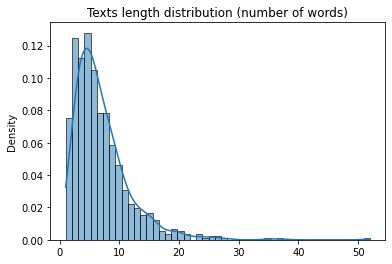

In [5]:
text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)");

### Fine-tuning BERT

In [6]:
MODEL_NAME = 'dbmdz/bert-base-turkish-128k-cased'
MAX_LENGTH = 50  # We truncate anything after the 200-th word to speed up training

config = BertConfig.from_pretrained(MODEL_NAME)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, 
                            max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, 
                           max_length=MAX_LENGTH, return_tensors="tf")

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

sample_text = "yemek iyi ama servis kötü"
tokenizer.decode(tokenizer(sample_text)["input_ids"])

Downloading:   0%|          | 0.00/386 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

2022-05-26 22:05:20.756903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 22:05:20.758080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 22:05:20.758761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 22:05:20.760763: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

'[CLS] yemek iyi ama servis kötü [SEP]'

In [7]:
for x, y in train_dataset.take(1):
    print(x)

{'input_ids': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([     2, 111668,   1041,   6058,   6550,   5878,      3,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(50,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0

In [8]:
train_labels.shape[1]

32

In [9]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, 
            "precision": precision, 
            "recall": recall, 
            "f1": f1}

In [10]:
transformer_model = TFBertModel.from_pretrained(
    MODEL_NAME, 
    output_hidden_states=False
)

Downloading:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

Some layers from the model checkpoint at dbmdz/bert-base-turkish-128k-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-128k-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
bert = transformer_model.layers[0]

# The input is a dictionary of word identifiers 
input_ids = Input(shape=(MAX_LENGTH,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Here we select the representation of the first token ([CLS]) for classification
# (a.k.a. "pooled representation")
bert_model = bert(inputs)[0][:, 0, :] 

# Add a dropout layer and the output layer
dropout = Dropout(0.2, name='pooled_output')(bert_model)

x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1))(dropout)

x = tf.keras.layers.Conv1D(32, 3, activation = tf.nn.silu)(x)
x = tf.keras.layers.MaxPool1D(3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv1D(64, 3, activation = tf.nn.silu)(x)
x = tf.keras.layers.MaxPool1D(3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv1D(128, 3, activation = tf.nn.silu)(x)
x = tf.keras.layers.MaxPool1D(3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.GlobalMaxPool1D()(x)

# pooled_output = dropout(bert_model, training=False)
output_bert = Dense(
    units=train_labels.shape[1],
    activation="sigmoid",  # Choose a sigmoid for multi-label classification
    name='output_bert'
)(x)

In [12]:

model = Model(inputs=inputs, outputs=output_bert, name='BERT_MultiLabel')
model.summary()

Model: "BERT_MultiLabel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 184345344 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
lambda (Lambda)              (None, 768, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 766, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 255, 32)       

In [13]:
y_pred = tf.convert_to_tensor([[0, 1], [1, 1]])
y_true = tf.convert_to_tensor([[1, 1], [0, 1]])
tf.cast(tf.math.reduce_all(y_pred == y_true, axis=1), tf.float32)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [14]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

### TRAIN MODEL

In [15]:
!pip install tensorflow_addons

In [16]:
from tensorflow_addons.metrics import F1Score

In [17]:
loss = BinaryCrossentropy()
optimizer = Adam(1e-5)
metrics = [
    F1Score(num_classes = train_labels.shape[1],
           average = 'micro',
           threshold = 0.5),
    "binary_accuracy", 
    AUC(name="average_precision", 
        curve="PR", 
        multi_label=True)
]
 
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

training_history = model.fit(
    train_dataset.shuffle(1000).batch(4), 
    epochs=8, 
    batch_size=16, 
    validation_data=test_dataset.batch(4)
)

Epoch 1/8


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['token_type_ids', 'attention_mask'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
2022-05-26 22:06:50.379811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-26 22:06:54.859047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


218/218 [==============================] - 45s 107ms/step - loss: 1.1953 - f1_score: 0.0648 - binary_accuracy: 0.5618 - average_precision: 0.0453 - val_loss: 0.7625 - val_f1_score: 0.0855 - val_binary_accuracy: 0.4806 - val_average_precision: 0.0627
Epoch 2/8
218/218 [==============================] - 20s 92ms/step - loss: 0.6743 - f1_score: 0.0631 - binary_accuracy: 0.6842 - average_precision: 0.0463 - val_loss: 0.3983 - val_f1_score: 0.0743 - val_binary_accuracy: 0.8756 - val_average_precision: 0.0665
Epoch 3/8
218/218 [==============================] - 20s 93ms/step - loss: 0.4577 - f1_score: 0.0645 - binary_accuracy: 0.7846 - average_precision: 0.0419 - val_loss: 0.2429 - val_f1_score: 0.0307 - val_binary_accuracy: 0.9275 - val_average_precision: 0.0691
Epoch 4/8
218/218 [==============================] - 20s 91ms/step - loss: 0.3270 - f1_score: 0.0646 - binary_accuracy: 0.8661 - average_precision: 0.0429 - val_loss: 0.2002 - val_f1_score: 0.0199 - val_binary_accuracy: 0.9576 - val

In [18]:
benchmarks = model.evaluate(
    test_dataset.batch(16), 
    return_dict=True, 
    batch_size=16
)

14/14 [==============================] - 1s 61ms/step - loss: 0.1713 - f1_score: 0.0202 - binary_accuracy: 0.9581 - average_precision: 0.0690


In [19]:
print(benchmarks)

{'loss': 0.1712544709444046, 'f1_score': 0.020202018320560455, 'binary_accuracy': 0.9581422209739685, 'average_precision': 0.06902506947517395}


In [20]:
def convert(label_string, label_onehot):
    labels = []
    for i, label in enumerate(label_string):
        if label_onehot[i]:
            labels.append(label)
    if len(labels) == 0:
        labels.append("NEUTRAL")
    return labels

In [21]:
predictions = model.predict(test_dataset.batch(batch_size=8).take(2))
y=[]
print("10 sample prediction")
for (pred,(a,b)) in zip(predictions, test_dataset.take(10)):
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    print("predicted:", pred, str(convert(label_names, pred)),
         "Actual Label: ("+str(convert(label_names, b.numpy())) +")")
    y.append(b.numpy())

10 sample prediction
predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] ['NEUTRAL'] Actual Label: (['neutral - FOOD#PRICES', 'neutral - FOOD#STYLE_OPTIONS'])
predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] ['NEUTRAL'] Actual Label: (['negative - RESTAURANT#GENERAL'])
predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] ['NEUTRAL'] Actual Label: (['negative - FOOD#QUALITY'])
predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] ['NEUTRAL'] Actual Label: (['positive - DRINKS#STYLE_OPTIONS', 'positive - SERVICE#GENERAL'])
predicted: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] ['NEUTRAL'] Actual Label: (['negative - FOOD#QUALITY', 'negative - SERVICE#GENERAL', 'positive - AMBIENCE#GENERAL'])
predicted: [0.

In [29]:
predictions[:15]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.    

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [23]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [24]:
loaded_model.summary()

Model: "BERT_MultiLabel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 184345344 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
lambda (Lambda)              (None, 768, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 766, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 255, 32)       

In [25]:
model.save(f"fine_tuned_bert")

2022-05-26 22:10:13.455922: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
#import shutil
#shutil.make_archive('BERT_MODEL', 'zip', './')